In [32]:
import librosa
import librosa.display
from numpy import inf
import numpy as np
from numpy import inf
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
%matplotlib inline
import os
import scipy

In [12]:
f_path = '../samples/hyojinparis.wav'
wave, fs = librosa.load(f_path)
wave = wave / np.max(np.abs(wave), axis=0)
frame_len, frame_shift = _get_frame()
# stft = librosa.stft(wave, hop_length=frame_shift, win_length=frame_len)

In [13]:
noiseDB_mean = {
    "Train": 0.2737,
    "Airport": 0.2157,
    "Street":0.2836,
    "Exhibition": 0.2671,
    "Station": 0.1778,
    "Restaurant": 0.1865,
    "Car": 0.2611,
    "Babble": 0.2983,
}

noiseDB_var = {
    "Train": 0.0708,
    "Airport": 0.1116,
    "Street": 0.0688,
    "Exhibition": 0.0674,
    "Station": 0.0685,
    "Restaurant": 0.1066,
    "Car": 0.0770,
    "Babble": 0.0891,
}

noiseDB = [
    noiseDB_mean,
    noiseDB_var,
]

In [14]:
def _get_frame(frame_sample_ms=20, shift_sample_ms=10):
    """
    input: frame_sample_ms(samples of window, ms단위, int)
           shift_sample_ms(samples of shift, ms단위, int)
    todo: frame과 hop_frame의 길이 안의 samples를 계산
    return: frame_len, frame_shift 
            자료형은 int
    """
    frame_len = int(frame_sample_ms*fs/1000) # frame_len = len_sample(ms) 만큼의 samples
    frame_shift = int(shift_sample_ms*fs/1000)
    return frame_len, frame_shift

In [15]:
"""
Entropy
"""
def _get_entropy(stft):
    """
    stft : numpy_array
           stft = librosa.stft(wavefile)
    stft된 배열의 entropy 배열을 구하는 것.
    크기는 stft와 동일\n"
    """
    Y = np.abs(stft)
    sqr_Y = Y ** 2
    div_Y = sqr_Y / np.sum(sqr_Y, axis=0)
    oneofpart = div_Y * np.log2(div_Y) * (-1)
    entropy = np.sum(oneofpart, axis=0)
    return entropy

def get_entropy_element(wave):
    frame_len, frame_shift = _get_frame()
    stft = librosa.stft(wave, hop_length=frame_shift, win_length=frame_len)
    Y = np.abs(stft)
    sqr_Y = Y ** 2
    div_Y = sqr_Y / np.sum(sqr_Y, axis=0)
    oneofpart = div_Y * np.log2(div_Y) * (-1)
    entropy = np.sum(oneofpart, axis=0)
    entropy[entropy == inf]=0
    entropy = np.nan_to_num(entropy)
    return entropy

In [16]:
"""
Harmonics
"""
def _get_hpeak(stft):
    """
    hpeak와 fk를 리턴하는 함수
    hpeak는 peak된 배열
    """
#     stft, _ = librosa.decompose.hpss(stft)
    hpeak = np.zeros_like(stft)
    hpeak = np.abs(hpeak)
    fk = np.zeros((stft.shape[1],))
    for i in range(stft.shape[1]): # 열기준 세로뭉텅이 자르기
        abs_stft = np.abs(stft[:, i])
        flag = 0
        for idx, elm in enumerate(abs_stft):
            if (idx == 0) or (idx == stft.shape[0] - 1):
                pass
            else:
                if (abs_stft[idx] > abs_stft[idx-1]) and (abs_stft[idx] > abs_stft[idx+1]):
                    hpeak[idx, i] = elm
                    if flag == 0:
                        fk[i,] = idx
                        flag = 1
                else:
                    pass
    return hpeak, fk

def _get_column_harmonic(column_hpeak):
    idx_col = np.where(column_hpeak != 0.0)[0]
    N = idx_col.shape[0]
    if N == 0:
        return 0
    mean_col = 0.0
    var_col = 0.0
    dist_col = 0.0
    tmp = 0.0
    for idx in idx_col:
        tmp = column_hpeak[idx]
        mean_col += tmp
    mean_col = mean_col/N
    tmp = 0.0
    for idx in idx_col:
        tmp = (column_hpeak[idx]-mean_col)**2
        var_col += tmp
    var_col = var_col/N
    tmp = 0.0
    for idx, elm in enumerate(idx_col):
        if idx != 0:
            tmp = (np.abs(column_hpeak[idx_col[idx]] - column_hpeak[idx_col[idx-1]]))/N
        else:
            tmp = column_hpeak[idx] / N
        dist_col += tmp
    return dist_col

def _get_all_harmonics(hpeak):
    blankarray = np.zeros((hpeak.shape[1],))
    for i in range(hpeak.shape[1]):
        blankarray[i] = _get_column_harmonic(hpeak[:,i])
    harmonics = blankarray
    return harmonics

def get_harmonics_element(wave):
    frame_len, frame_shift = _get_frame()
    stft = librosa.stft(wave, hop_length=frame_shift, win_length=frame_len)
    hpeak, fk = _get_hpeak(stft=stft)
    harmonics = _get_all_harmonics(hpeak=hpeak)
    return harmonics

In [17]:
"""
SEM
"""
def ftobark(stft, fs):
    freqs = librosa.core.fft_frequencies(n_fft=stft.shape[0]*2-1, sr=fs)
    bark_freqs = 13*np.arctan(0.00076*freqs)+3.5*np.arctan(((freqs/7500)**2))
    bark_freqs_bin = bark_freqs.astype(int)
    bark_freqs_bin = bark_freqs_bin + 1
    zeroscore_idx = np.where(freqs < 20)[0]
    if zeroscore_idx.shape[0] != 0:
        for idx in zeroscore_idx:
            bark_freqs_bin[idx] = 0
    
    return bark_freqs_bin

def _make_mu(stft, fs):
    abs_stft = np.abs(stft)
    bf = ftobark(stft, fs)
    N = bf[-1]+1
    fre_sum = np.sum(abs_stft, axis=0)
    mu = fre_sum / N
    return mu

def _get_column_B(stft,stft_column, fs):
    bf = ftobark(stft, fs)
    N = bf[-1] + 1
    Bshell = np.arange(N, dtype=float)
    stft_column = np.abs(stft_column)
    for i in range(N):
        idx_array = np.where(bf == i)[0]
        toadd = 0.0
        for idx in idx_array:
            toadd += stft_column[idx]
#         print(toadd, i)
        Bshell[i] = toadd
    return Bshell

def _get_all_column_B(stft, fs):
    n = stft.shape[1]
#     toreturn = _get_column_B(stft, stft[:, i], fs)
    for i in range(n):
        forreshape = _get_column_B(stft, stft[:, i], fs)
        forstack = forreshape.reshape((forreshape.shape[0],1))
        if i==0:
            forreturn = forstack
        else:
            forreturn = np.hstack([forreturn, forstack])
    B = forreturn
    
    return B

def _get_Pmin(B):
    """
    B는 3.9의 B
    """
    return np.min(B, axis=0)

def _get_PSR(B, Pmin, mu):
    PSR = (B - Pmin)/mu
    return PSR

def _get_Bbar(B, PSR):
    Bbar = B * PSR
    return Bbar

def _get_muhat(Bbar):
    muhat = np.mean(Bbar, axis=0)
    return muhat

def _get_sigmahat(muhat, Bbar):
    sigmahat = np.sqrt(np.mean((Bbar - muhat)**2, axis=0))
    return sigmahat

def _get_Bhat(Bbar, muhat, sigmahat):
    Bhat = Bbar*((Bbar - muhat)/sigmahat)
    Bhat = np.nan_to_num(Bhat)
    return Bhat

def get_sem_element(wave, fs):
    """
    muhat: Array
           (1, stft.shape[1])
    sigmahat : Array
               (1. stft.shape[1])
    """
    frame_len, frame_shift = _get_frame()
    stft = librosa.stft(wave, hop_length=frame_shift, win_length=frame_len)
    B = _get_all_column_B(stft, fs)
    Pmin = _get_Pmin(B)
    mu = _make_mu(fs=fs, stft=stft)
    PSR = _get_PSR(B, Pmin, mu)
    Bbar = _get_Bbar(B, PSR)
    muhat = _get_muhat(Bbar)
    sigmahat = _get_sigmahat(muhat, Bbar)
    muhat = np.nan_to_num(muhat)
    sigmahat = np.nan_to_num(sigmahat)
    return muhat, sigmahat

"""
Short-term energy
"""
def shortTermEnergy(stft):
    doublestft = np.abs(stft)**2
    lenframe = stft.shape[0]
    return np.sum(doublestft, axis=0)/lenframe

"""
Zero-crossing rate
"""
def get_ZCR(wave, pad=0):
    frame_len, frame_shift = _get_frame()
    zcr = librosa.feature.zero_crossing_rate(wave+pad, frame_length=frame_len, hop_length=frame_shift)
    zcr = zcr[0]
    return zcr

In [18]:
def checkpartByVariance(wave):
    """
    DB의 값에서 나온 분산을 이용해서 h0, h1 결정
    h1 : numpy array, Speech+Noise section의 index들을 배열로 리턴
    h0 : numpy array, Noise section의 index들을 배열로 리턴
    """
    frame_len, frame_shift = _get_frame()
    stft = librosa.stft(wave, hop_length=frame_shift, win_length=frame_len)
    abs_stft = np.abs(stft)
    var_abs_stft = np.var(abs_stft, axis=0)
    gamma = (var_abs_stft/0.082475)
    return np.where(gamma>1.0)[0], np.where(gamma<=1.0)[0] # noise+speech

def _get_normEH(wave):
    """
    harmonics/entropy를 표준화하여 리턴
    normEH: 1xtime-domain-frame(numpy array)
    """
    frame_len, frame_shift = _get_frame()
    stft = librosa.stft(wave, hop_length=frame_shift, win_length=frame_len)
    entropy = _get_entropy(stft=stft)
    entropy = np.nan_to_num(entropy)
    entropy[entropy == 0]=5
    harmonics = get_harmonics_element(wave=wave)
    normEH = harmonics/entropy
    normEH = normEH/np.max(normEH)
    return normEH

def get_wave_point(wave, cl=0.03, cutEH=0.95, cutN=0.95):
    """
    normEH로 음성부분을 포함한 후 normN으로 비음성부분을 제거하는 함수
    maskingEH: 1xtime-domain-frame(numpy array) 값은 1,0만 있음
    """
    normEH = _get_normEH(wave)
    musigma, muhat = get_sem_element(fs=fs, wave=wave)
    Nmask = musigma + muhat
    normN = Nmask/np.max(Nmask)
    toadd=0.0
    floor_EH = np.zeros_like(normEH)
    for i in range(20):
        toadd = 1-cl*i
        floor_EH += np.floor(normEH+toadd)
    floor_EH = floor_EH/np.max(floor_EH)
    floor_EH = np.floor(floor_EH+cutEH)
    floor_N = np.floor(normN+cutN)
    tominusarray = np.zeros_like(floor_N)
    for idx, elm in enumerate(floor_EH):
        if elm == 1:
            if floor_N[idx] == 0:
                tominusarray[idx] = 1
    maskingEH = floor_EH - tominusarray
    return maskingEH

def check_speech(wavepointarray, frameoffset=5):
    """
    wavepointarray에 get_wave_point()의 값을 대입
    speech 부분에 offset을 주어서 리턴하는 함수
    return: 1xtime-domain-frame(numpy array)
    maskingEH에 offset을 도입한 것과 같다.
    """
    wavepointarray[-1]=0
    startflag=0
    startpoint = 0
    endpoint = 0
    detectset = []
    for idx, elm in enumerate(wavepointarray):
        if idx < wavepointarray.shape[0]-4: 
            if startflag==0: #startpoint를 찾아야돼!
                if (wavepointarray[idx]==1 # speech start 확인
                   and (wavepointarray[idx+1]+wavepointarray[idx+2])!=0
                   and wavepointarray[idx+3]==1):
                    startflag = 1
                    startpoint = idx
            else: #endpoint 찾기, startflag==1
                if (wavepointarray[idx]==0 
                   and (wavepointarray[idx+1]+wavepointarray[idx+2])!=2
                   and wavepointarray[idx+3]==0):
                    endpoint = idx
                    startflag=0
                    detectset.append((startpoint, endpoint))
        else:
            if startflag==1:
                if wavepointarray[idx]==0:
                    endpoint = idx
                    startflag=0
                    detectset.append((startpoint, endpoint))
    if len(detectset)>=1:
        for i in detectset:
            startcut=frameoffset
            endcut=frameoffset
            if i[0]<=5:
                startcut=i[0]
            else:
                pass
            if i[1] >= (wavepointarray.shape[0]-endcut+1):
                endcut = wavepointarray.shape[0]-i[1]
            else:
                pass
            wavepointarray[(i[0]-startcut):(i[1]+endcut)]=1
    else:
        raise "Can't detect speech part."
    return wavepointarray

def check_final(wave, cl=0.05, cutEH=0.98, cutN=0.98,frameoffset=5):
    """
    이것만 하면 돼!
    """
    maskingEH = get_wave_point(wave, cl, cutEH, cutN)
    H1, H0 = checkpartByVariance(wave=wave)
    for i in H0:
        maskingEH[i]=0
    print("Checking the speech")
    speechpart = check_speech(wavepointarray=maskingEH, frameoffset=frameoffset)
    finalarray = speechpart
    return finalarray

In [19]:
# (1/fs)*final.shape[0]*frame_shift
def pointset(finalarray):
    finalarray[-1] = 0
    startflag = 0
    startpoint = 0
    endpoint = 0
    pointlst = []
    for idx, elm in enumerate(finalarray):
        if startflag==0:
            if elm==1:
                startflag = 1
                startpoint = idx
            else:
                pass
        elif startflag==1:
            if elm==0:
                startflag = 0
                endpoint = idx
                pointlst.append((startpoint, endpoint))
            else:
                pass
    return pointlst

def _audioseg(startframe, endframe, frame_shift, fs):
    """
    start, end
    """
    starttime = startframe * (1/fs) * frame_shift * 1000
    endtime = endframe * (1/fs) * frame_shift * 1000
    newAudio = AudioSegment.from_wav(f_path)
    newAudio = newAudio[starttime: endtime]
    return newAudio

def makeWavSegFile(newAudio,dirname="shinminadir", i=0):
    try:
        export_path = 'C:\\Users\\jmlik\\Desktop\\Work\\mywork\\simplevad\\auditok_eg\\'+dirname
        mkdir_mina = os.mkdir(export_path)
    except:
        export_path = 'C:\\Users\\jmlik\\Desktop\\Work\\mywork\\simplevad\\auditok_eg\\'+dirname
    return newAudio.export(export_path+'\\newmina' +str(i)+ '.wav', format="wav")

    
def makeWavFile(pointset, frame_shift, fs):
    for idx,i in enumerate(pointset):
        startframe = i[0]
        endframe = i[1]
        audioseg = _audioseg(startframe, endframe, frame_shift, fs)
        makeWavSegFile(audioseg, i=idx)
    return "Finish"

In [125]:
"""
noise 종류는 010, 0110, 01110
앞뒤중 하나가 노이즈값에 3프레임 건너서 스피치가 나올 때 (ex. 111100010001111)
이는 speech 뭉텅이에 합쳐주고 (앞에 합치는 것을 우선순위로 잡는다.)
그 외의 경우는 노이즈 제거
"""
def denoisingAfterFinalArray(finalarray):
    """
    input: finalarray(offset처리를 마친 array)
    """
    for idx, elm in enumerate(finalarray):
        if (idx>=7) and (idx <= finalarray.shape[0]-1-10): # 양끝고려
            if (finalarray[idx] == 1 and # 010
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 0):
                if np.sum(finalarray[idx-5:idx-1])==4:
                    finalarray[idx-5:idx] = 1
                elif np.sum(finalarray[idx+2:idx+6])==4:
                    finalarray[idx:idx+6] = 1
                elif np.sum(finalarray[idx-6:idx-2])==4:
                    finalarray[idx-6:idx] = 1
                elif np.sum(finalarray[idx+3:idx+7])==4:
                    finalarray[idx:idx+7] = 1
                elif np.sum(finalarray[idx-7:idx-3])==4:
                    finalarray[idx-7:idx] = 1
                elif np.sum(finalarray[idx+4:idx+8])==4:
                    finalarray[idx:idx+8] = 1
                else:
                    finalarray[idx] = 0

            elif (finalarray[idx] == 1 and # 0110
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 1 and
                finalarray[idx+2] == 0):
                if np.sum(finalarray[idx-5:idx-1])==4:
                    finalarray[idx-5:idx] = 1
                elif np.sum(finalarray[idx+3:idx+7])==4:
                    finalarray[idx:idx+7] = 1
                elif np.sum(finalarray[idx-6:idx-2])==4:
                    finalarray[idx-6:idx] = 1
                elif np.sum(finalarray[idx+4:idx+8])==4:
                    finalarray[idx:idx+8] = 1
                elif np.sum(finalarray[idx-7:idx-3])==4:
                    finalarray[idx-7:idx] = 1
                elif np.sum(finalarray[idx+5:idx+9])==4:
                    finalarray[idx:idx+9] = 1
                else:
                    finalarray[idx] = 0
                    finalarray[idx+1] = 0

            elif (finalarray[idx] == 1 and # 01110
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 1 and
                finalarray[idx+2] == 1 and
                finalarray[idx+3] == 0):
                if np.sum(finalarray[idx-5:idx-1])==4:
                    finalarray[idx-5:idx] = 1
                elif np.sum(finalarray[idx+4:idx+8])==4:
                    finalarray[idx:idx+8] = 1
                elif np.sum(finalarray[idx-6:idx-2])==4:
                    finalarray[idx-6:idx] = 1
                elif np.sum(finalarray[idx+5:idx+9])==4:
                    finalarray[idx:idx+9] = 1
                elif np.sum(finalarray[idx-7:idx-3])==4:
                    finalarray[idx-7:idx] = 1
                elif np.sum(finalarray[idx+6:idx+10])==4:
                    finalarray[idx:idx+10] = 1
                else:
                    finalarray[idx] = 0    
                    finalarray[idx+1] = 0
                    finalarray[idx+2] = 0
        if idx<7:
            if idx==0:
                finalarray[idx]=0
            if 0<idx<6:
                if (finalarray[idx] == 1 and # 010
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 0):
                    if np.sum(finalarray[idx+1:idx+5])==4:
                        finalarray[idx:idx+5]=1
                    elif np.sum(finalarray[idx+2:idx+6])==4:
                        finalarray[idx:idx+6]=1
                    elif np.sum(finalarray[idx+3:idx+7])==4:
                        finalarray[idx:idx+7]=1
                    else:
                        finalarray[idx]=0
            
                elif (finalarray[idx] == 1 and # 0110
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 1 and
                finalarray[idx+1] == 0):
                    if np.sum(finalarray[idx+3:idx+7])==4:
                        finalarray[idx:idx+7] = 1
                    elif np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    elif np.sum(finalarray[idx+5:idx+9])==4:
                        finalarray[idx:idx+9] = 1
                    else:
                        finalarray[idx] = 0
                        finalarray[idx+1] = 0
            
            
                elif (finalarray[idx] == 1 and # 01110
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 1 and
                finalarray[idx+2] == 1 and
                finalarray[idx+3] == 0):
                    if np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    elif np.sum(finalarray[idx+5:idx+9])==4:
                        finalarray[idx:idx+9] = 1
                    elif np.sum(finalarray[idx+6:idx+10])==4:
                        finalarray[idx:idx+10] = 1
                    else:
                        finalarray[idx] = 0    
                        finalarray[idx+1] = 0
                        finalarray[idx+2] = 0
            
            if idx==6:
                if (finalarray[idx] == 1 and # 010
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 0):
                    if np.sum(finalarray[1:5])==4:
                        finalarray[idx-1:idx+1]=0
                    elif np.sum(finalarray[idx+1:idx+5])==4:
                        finalarray[idx:idx+5]=1
                    elif np.sum(finalarray[idx+2:idx+6])==4:
                        finalarray[idx:idx+6]=1
                    elif np.sum(finalarray[idx+3:idx+7])==4:
                        finalarray[idx:idx+7]=1
                    else:
                        finalarray[idx]=0
            
                elif (finalarray[idx] == 1 and # 0110
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 1 and
                finalarray[idx+1] == 0):
                    if np.sum(finalarray[1:5])==4:
                        finalarray[idx-1:idx+1]=0
                    elif np.sum(finalarray[idx+3:idx+7])==4:
                        finalarray[idx:idx+7] = 1
                    elif np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    elif np.sum(finalarray[idx+5:idx+9])==4:
                        finalarray[idx:idx+9] = 1
                    else:
                        finalarray[idx] = 0
                        finalarray[idx+1] = 0
            
            
                elif (finalarray[idx] == 1 and # 01110
                finalarray[idx-1] == 0 and
                finalarray[idx+1] == 1 and
                finalarray[idx+2] == 1 and
                finalarray[idx+3] == 0):
                    if np.sum(finalarray[1:5])==4:
                        finalarray[idx-1:idx+1]=0
                    elif np.sum(finalarray[idx+4:idx+8])==4:
                        finalarray[idx:idx+8] = 1
                    elif np.sum(finalarray[idx+5:idx+9])==4:
                        finalarray[idx:idx+9] = 1
                    elif np.sum(finalarray[idx+6:idx+10])==4:
                        finalarray[idx:idx+10] = 1
                    else:
                        finalarray[idx] = 0    
                        finalarray[idx+1] = 0
                        finalarray[idx+2] = 0
    return finalarray    

In [473]:
def get_speech_section(daf, fs, frame_shift):
    startflag = 0
    daf[-1] = 0
    daf[0] = 0
    startframe = 0
    endframe = 0
    Isspeech = []
    Tdspeech = []
    Fdspeech = []
    starttime = 0.0
    endtime = 0.0
    Tstarttime = 0
    Tendtime = 0
    Fstarttime = 0
    Fendtime = 0
    toadd = 0
    costcount = 0
    totaltime = 0.0
    toaddtime = 0.0
    for idx, elm in enumerate(daf):
        if startflag==0:
            if elm==1:
                startflag=1
                startframe=idx
            else:
                pass   
        elif startflag==1:
            if elm==1:
                pass
            else: # elm==0:
                startflag=0
                endframe=idx-1
                starttime = (1/fs)*startframe*frame_shift
                endtime = (1/fs)*endframe*frame_shift
                Fstarttime = startframe
                Fendtime = endframe
                Tstarttime = startframe*frame_shift
                Tendtime = endframe*frame_shift
                Isspeech.append({'startTime':starttime,
                                'endTime':endtime,
                                'word':""})
                Tdspeech.append({'startTime':Tstarttime,
                                'endTime':Tendtime,
                                'word':""})
                Fdspeech.append({'startTime':Fstarttime,
                                'endTime':Fendtime,
                                'word':""})
#                 toadd = int((endtime-starttime)/15)+1
#                 costcount += toadd
#                 toaddtime = endtime-starttime
#                 totaltime += toaddtime
    return Isspeech, Tdspeech, Fdspeech  # costcount, totaltime

#finalarray, daf, isspeech
def makeForm(wave, fs, Isspeech,step):
    totalWave = np.arange(0, dtype=float)
    for i in Isspeech:
        startframe = int(i["startTime"]*fs)
        endframe = int(i["endTime"]*fs) + 1
        waveToAdd = np.hstack([wave[startframe:endframe], np.zeros((int(fs*step),))])
        totalWave = np.hstack([totalWave, waveToAdd])
    return totalWave

def makeBridge(dAF, step):
    """
    denoisingAfterFinalArray()의 값을 인풋으로 하여
    지정 프레임내에 다시 speech가 시작하는 부분을 잇는 함수
    """
    DAF = dAF.copy()
    startframe = 0
    endframe = 0
    startflag = 0
    bridgelist = []
    for idx, elm in enumerate(DAF):
        if idx != (DAF.shape[0]-1):
            if startflag==0:
                if DAF[idx]==1 and DAF[idx+1]==0:
                    startflag=1
                    startframe=idx+1
                else:
                    pass
            else: # startflag==1
                if DAF[idx+1]==1:
                    startflag=0
                    endframe = idx
                    bridgelist.append((startframe,endframe))
                else:
                    pass
    for i in bridgelist:
        if (i[1] - i[0] + 1)<=step:
            DAF[i[0]:i[1]+1] = 1
        else:
            pass
    return DAF

# 조효진

In [297]:
hjfinal_zero = check_final(wave=wave, frameoffset=6, cl=0.05, cutN=0.97, cutEH=0.98)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Checking the speech


In [298]:
daf = denoisingAfterFinalArray(finalarray=hjfinal_zero)
isspeech, costcnt, runtime  = get_speech_section(daf=daf, frame_shift=frame_shift, fs=fs)
hjbridge = makeBridge(daf, step=30)

In [438]:
# hjfinal_zero2 = check_final(wave=wave, frameoffset=0, cl=0.05, cutN=0.97, cutEH=0.98)
daf2 = denoisingAfterFinalArray(finalarray=hjfinal_zero2)
hjbridge2 = makeBridge(daf2, step=10)

In [474]:
# hjfinal_zero3 = check_final(wave=wave, frameoffset=0, cl=0.05, cutN=0.99, cutEH=0.99)
daf3 = denoisingAfterFinalArray(finalarray=hjfinal_zero3)
isspeech, tdspeech, fdspeech  = get_speech_section(daf=daf3, frame_shift=frame_shift, fs=fs)
hjbridge3 = makeBridge(daf3, step=10)

In [372]:
hjbridge_zero = makeBridge(hjfinal_zero, step=30)

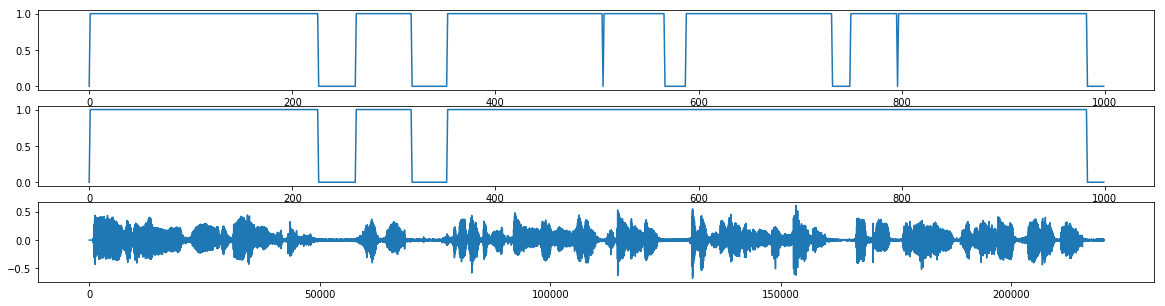

In [215]:
plt.figure(figsize=(20,5))
plt.subplot(311)
plt.plot(daf[:1000])
plt.subplot(312)
plt.plot(hjbridge[:1000])
plt.subplot(313)
plt.plot(wave[:1000*frame_shift])

In [40]:
form = makeForm(wave, fs, isspeech, 1)
scipy.io.wavfile.write('0.3secstep.wav', fs, form)

# 설민석

In [57]:
smswave, smsfs = librosa.load('../samples/sms.wav')

In [87]:
smsfinal_zero = check_final(wave=smswave, frameoffset=15, cl=0.05, cutN=0.99, cutEH=0.99)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Checking the speech


In [89]:
smsdaf = denoisingAfterFinalArray(finalarray=smsfinal_zero)
smsisspeech, costcnt, runtime  = get_speech_section(daf=smsdaf, frame_shift=frame_shift, fs=fs)

In [63]:
smsform = makeForm(smswave, fs, smsisspeech, 1)
scipy.io.wavfile.write('sms.wav', fs, smsform)

In [133]:
smsfinal_test = check_final(wave=smswave[:5000*frame_shift], frameoffset=15, cl=0.05, cutN=0.96, cutEH=0.98)
smsdaf_test = denoisingAfterFinalArray(finalarray=smsfinal_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Checking the speech


In [141]:
smsisspeech_test, costcnt, runtime  = get_speech_section(daf=smsdaf_test, frame_shift=frame_shift, fs=fs)
smsform_test = makeForm(smswave[:10000*frame_shift], fs, smsisspeech_test, 1)
scipy.io.wavfile.write('sms_test.wav', fs, smsform_test)

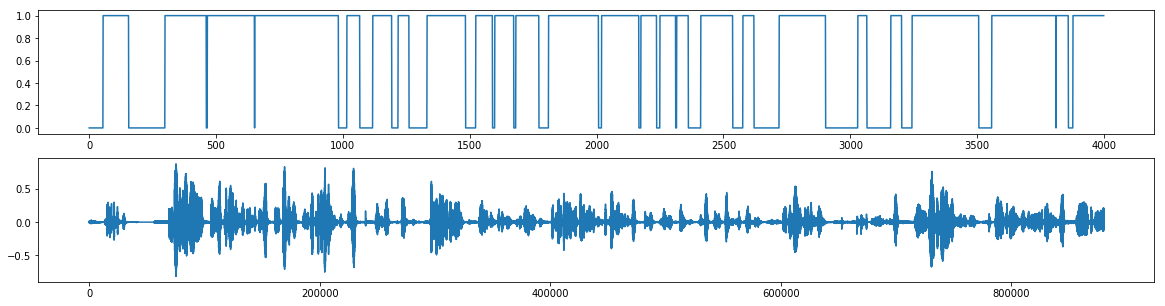

In [142]:
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(smsdaf_test[1000:5000])
plt.subplot(212)
plt.plot(smswave[1000*frame_shift:5000*frame_shift])

# Jeju

In [97]:
jjwave, jjfs = librosa.load('../samples/jeju.wav')

In [131]:
jjfinal_test = check_final(wave=jjwave[:5000*frame_shift], frameoffset=10, cl=0.05, cutN=0.95, cutEH=0.85)
jjdaf_test = denoisingAfterFinalArray(finalarray=jjfinal_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Checking the speech


In [103]:
jjisspeech_test, costcnt, runtime  = get_speech_section(daf=jjdaf_test, frame_shift=frame_shift, fs=fs)
jjform_test = makeForm(jjwave[:10000*frame_shift], fs, jjisspeech_test, 1)
scipy.io.wavfile.write('jj_test.wav', fs, jjform_test)

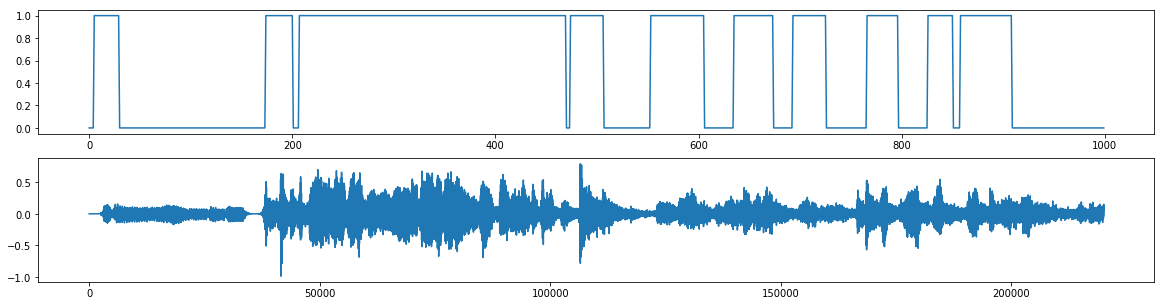

In [132]:
plt.figure(figsize=(20,5))
plt.subplot(211)
plt.plot(jjfinal_test[:1000])
plt.subplot(212)
plt.plot(jjwave[:1000*frame_shift])

# Hojin data 처리

In [218]:
import csv
csv_hj_path = "../samples/hyojin.csv"

In [230]:
data_hj = []
with open(csv_hj_path, 'r', encoding='utf-16') as reader:
    for line in reader:
        data_hj.append(line.split('"')[1])

In [228]:
for idx,i in enumerate(data_hj):
    data_hj[idx] = i.replace(']', '[').split('[')[1]

In [245]:
len(data_hj[0].split(","))

9

In [261]:
def _stringDataToRealData(stringData):
    """
    데이터 리스트로 리턴
    """
    toReturnLst = []
    numOfWord = int((len(stringData.split(",")))/3)
    for i in range(numOfWord):
        startTime = float(stringData.split(",")[i*3].split("'")[3].replace("s",""))
        endTime = float(stringData.split(",")[i*3 + 1].split("'")[3].replace("s",""))
        word = (stringData.split(",")[i*3 + 2].split("'")[3].replace("s",""))
        toReturnLst.append({'startTime': startTime,
                           'endTime': endTime,
                           'word': word})
    return toReturnLst

In [262]:
def getAllRealData(totalStringData):
    toReturn = []
    for i in totalStringData:
        toReturn.append(_stringDataToRealData(i))
    return toReturn

In [263]:
dataHJ = getAllRealData(data_hj)

In [274]:
def _secToTimeF(data_elm, fs, frame_shift):
    """
    getAllRealData 의 원소 하나를 인풋으로 받아서 time 도메인의 프레임으로 바꿔준다.
    """
    startframe = 0
    startfftf = 0
    endframe = 0
    endfftf = 0
    timeFrameLst = []
    fourierFrameLst = []
    for i in data_elm:
        startframe = int(i['startTime']*fs)
        endframe = int(i['endTime']*fs)
        timeFrameLst.append((startframe, endframe))
        startfftf = int(startframe/frame_shift)
        endfftf = int(endframe/frame_shift)
        fourierFrameLst.append((startfftf,endfftf))
    return timeFrameLst, fourierFrameLst

In [275]:
tfl, ffl = _secToTimeF(dataHJ[0], fs, frame_shift)

In [465]:
def showAll(wave,fftwave, data_elm, fs, frame_shift, offset=0):
    TFL, FFL = _secToTimeF(data_elm, fs, frame_shift)
    tdmainstart = TFL[0][0]
    tdmainend = TFL[-1][1]
    fflstart = FFL[0][0]
    fflend = FFL[-1][1]
    plt.figure(figsize=(14,5))
    plt.subplot(211)
    if tdmainstart>=(offset*frame_shift):
        offsetstart = offset*frame_shift
    else:
        offsetstart = tdmainstart
    if tdmainend<(wave.shape[0]-offset*frame_shift):
        offsetend = offset*frame_shift
    else:
        offsetend = wave.shape[0]-tdmainend
    if offset == 0:
        offsetstart=0
        offsetend=0
    plt.plot(wave[tdmainstart-offsetstart:tdmainend+offsetend])
    for i in TFL:
        plt.axvline(x=i[0]-(tdmainstart-offsetstart), color='r', linewidth=5)
        plt.axvline(x=i[1]-(tdmainstart-offsetstart), color='r', linestyle='--')
    if fflstart>=(offset):
        offsetstart = offset
    else:
        offsetstart = fflstart
    if fflend<(fftwave.shape[0]-offset):
        offsetend = offset
    else:
        offsetend = fftwave.shape[0]-tdmainend
    if offset == 0:
        offsetstart=0
        offsetend=0
    plt.subplot(212)
    plt.plot(fftwave[fflstart-offsetstart:fflend+offsetend])
    for i in FFL:
        plt.axvline(x=i[0]-(fflstart-offsetstart), color='r', linewidth=5)
        plt.axvline(x=i[1]-(fflstart-offsetstart)+0, color='r', linestyle='--')
    _playAudio(wave, data_elm, fs)
    ipd.display(ipd.Audio(wave[tdmainstart:tdmainend+1], rate=fs))
    print('Total Speech', (tdmainstart, tdmainend), (fflstart, fflend))
    return 'finish'

def _playAudio(wave, data_elm, fs):
    TFL, FFL = _secToTimeF(data_elm, fs, frame_shift)
    for idx, i in enumerate(TFL):
        start = i[0]
        end = i[1]
        ipd.display(ipd.Audio(wave[start-0*frame_shift:end+0*frame_shift], rate=fs))
        print('ㄴ'+data_elm[idx]['word'])
        print(TFL[idx], FFL[idx])

    return 'finish'

In [1]:
# showAll(wave, daf3, dataHJ[0], fs, frame_shift, offset=10)

In [478]:
def endpoint_HoleFixer():
    """
    1- 0- 1- 형태의 단어를 1- / 0- 1- 로 start end를 조정하는 함수
    """
def _endfixer():
    """
    뒤 10개 확인
    """
def _startfixer():
    """
    앞 4개 뒤 6개 확인
    """
def _holefixer():
    """
    end, start 확인 후 hole 확인
    """

In [2]:
# fdspeech